<a href="https://colab.research.google.com/github/jingvf/IDS/blob/main/gps_spoofing_test1Asymmetric%20Robustness%20in%20Ship%20AIS%20Spoofing%20Detection-A%20Study%20of%20Random%20Perturbation%20Stability%20and%20Adaptive%20Evasion%20Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report


In [23]:
# 读取数据
df = pd.read_csv('/content/drive/MyDrive/2026paper/gps_spoofing data.csv')

# 预览数据结构
print(df.head())
print(df['Label'].value_counts()) # 查看正负样本比例

        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367109910  2020-01-01 00:00:00  47.65925 -122.37875  0.0  342.3     95.0   
1  338127175  2020-01-01 00:00:00  47.64416 -122.31557  0.0  360.0    511.0   
2  367186210  2020-01-01 00:00:00  36.83719  -76.29111  0.0  360.0    511.0   
3  367182980  2020-01-01 00:00:00  29.93012  -93.87452  7.3  219.3    511.0   
4  368111750  2020-01-01 00:00:00  29.37558  -94.88956  0.0  119.9    266.0   

   speed_calc  acceleration  delta_heading  speed_ma  acceleration_ma  \
0         0.0           NaN            0.0       0.0              NaN   
1         0.0           NaN            0.0       0.0              NaN   
2         0.0           NaN            0.0       0.0              NaN   
3         0.0           NaN            0.0       0.0              NaN   
4         0.0           NaN            0.0       0.0              NaN   

   delta_heading_ma  LAT_pred   LON_pred  prediction_error   Label  
0               0

In [24]:
# 2️⃣ 基本信息
print("📌 数据基本信息：")
print(df.info())

print("\n📌 数据前5行：")
print(df.head())

# 3️⃣ 缺失值统计
print("\n📌 各字段缺失值统计：")
missing = df.isnull().sum()
print(missing[missing > 0])

# 4️⃣ 标签分布
print("\n📌 标签分布：")
print(df["Label"].value_counts())

print("\n📌 标签比例：")
print(df["Label"].value_counts(normalize=True))

# 5️⃣ 数值字段统计描述
print("\n📌 数值字段统计描述：")
print(df.describe())

# 6️⃣ 检查是否存在重复数据
duplicates = df.duplicated().sum()
print(f"\n📌 重复样本数量: {duplicates}")

📌 数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6351 entries, 0 to 6350
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MMSI              6351 non-null   int64  
 1   BaseDateTime      6351 non-null   object 
 2   LAT               6351 non-null   float64
 3   LON               6351 non-null   float64
 4   SOG               6351 non-null   float64
 5   COG               6351 non-null   float64
 6   Heading           6351 non-null   float64
 7   speed_calc        6351 non-null   float64
 8   acceleration      1462 non-null   float64
 9   delta_heading     6351 non-null   float64
 10  speed_ma          6351 non-null   float64
 11  acceleration_ma   1462 non-null   float64
 12  delta_heading_ma  6351 non-null   float64
 13  LAT_pred          6350 non-null   float64
 14  LON_pred          6350 non-null   float64
 15  prediction_error  6350 non-null   float64
 16  Label             6351 non-null 

问题1：acceleration 缺失 4889
问题 2：Heading 有异常值 511
问题 3：prediction_error 非常小


In [25]:
# 删除严重缺失特征
df = df.drop(columns=["acceleration", "acceleration_ma"])

# 处理Heading=511
df["Heading"] = df["Heading"].replace(511, np.nan)
df["Heading"] = df["Heading"].fillna(df["COG"])

# 删除 prediction 缺失
df = df.dropna()

# 标签编码
df["Label"] = df["Label"].map({"Normal": 0, "Spoofed": 1})

# 删除泄露特征
df = df.drop(columns=["LAT_pred", "LON_pred", "prediction_error"])

# 删除不用于模型的列
df = df.drop(columns=["MMSI", "BaseDateTime"])

In [26]:
# 2️⃣ 基本信息
print("📌 数据基本信息：")
print(df.info())

print("\n📌 数据前5行：")
print(df.head())

# 3️⃣ 缺失值统计
print("\n📌 各字段缺失值统计：")
missing = df.isnull().sum()
print(missing[missing > 0])

# 4️⃣ 标签分布
print("\n📌 标签分布：")
print(df["Label"].value_counts())

print("\n📌 标签比例：")
print(df["Label"].value_counts(normalize=True))

# 5️⃣ 数值字段统计描述
print("\n📌 数值字段统计描述：")
print(df.describe())

# 6️⃣ 检查是否存在重复数据
duplicates = df.duplicated().sum()
print(f"\n📌 重复样本数量: {duplicates}")

📌 数据基本信息：
<class 'pandas.core.frame.DataFrame'>
Index: 6350 entries, 0 to 6350
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LAT               6350 non-null   float64
 1   LON               6350 non-null   float64
 2   SOG               6350 non-null   float64
 3   COG               6350 non-null   float64
 4   Heading           6350 non-null   float64
 5   speed_calc        6350 non-null   float64
 6   delta_heading     6350 non-null   float64
 7   speed_ma          6350 non-null   float64
 8   delta_heading_ma  6350 non-null   float64
 9   Label             6350 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 545.7 KB
None

📌 数据前5行：
        LAT        LON  SOG    COG  Heading  speed_calc  delta_heading  \
0  47.65925 -122.37875  0.0  342.3     95.0         0.0            0.0   
1  47.64416 -122.31557  0.0  360.0    360.0         0.0            0.0   
2  36.83719  -76.29111  0.0  360.0 

In [27]:
# ===============================
# Clean Supervised Setup
# ===============================

# ========= 实验1：包含LAT/LON =========
features_with_pos = [
    "LAT", "LON",
    "SOG", "COG", "Heading",
    "speed_calc",
    "delta_heading",
    "speed_ma",
    "delta_heading_ma"
]

# ========= 实验2：不包含LAT/LON =========
features_no_pos = [
    "SOG", "COG", "Heading",
    "speed_calc",
    "delta_heading",
    "speed_ma",
    "delta_heading_ma"
]

In [28]:
X = df[features_no_pos]
y = df["Label"]

print("使用特征数:", X.shape[1])
print("总样本数:", X.shape[0])


# ===============================
# 3️⃣ 划分数据
# ===============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 标准化（用于LR）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ===============================
# 4️⃣ 评估函数
# ===============================

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n====== {model_name} ======")
    print("Accuracy:", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall:", round(rec, 4))
    print("F1-score:", round(f1, 4))
    print("ROC-AUC:", round(auc, 4))
    print("Confusion Matrix:\n", cm)

使用特征数: 7
总样本数: 6350


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import xgboost as xgb

# ===============================
# 5️⃣ 模型训练
# ===============================

# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_train_scaled, y_train)
evaluate_model(lr, X_test_scaled, y_test, "Logistic Regression")


# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test, "Random Forest")


# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])
)

xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test, "XGBoost")


====== Logistic Regression ======
Accuracy: 0.9669
Precision: 1.0
Recall: 0.7789
F1-score: 0.8757
ROC-AUC: 0.9568
Confusion Matrix:
 [[1080    0]
 [  42  148]]

====== Random Forest ======
Accuracy: 0.9961
Precision: 0.9793
Recall: 0.9947
F1-score: 0.9869
ROC-AUC: 0.9972
Confusion Matrix:
 [[1076    4]
 [   1  189]]

====== XGBoost ======
Accuracy: 0.9969
Precision: 0.9844
Recall: 0.9947
F1-score: 0.9895
ROC-AUC: 0.9986
Confusion Matrix:
 [[1077    3]
 [   1  189]]


In [30]:
鲁棒性分析
SHAP 可解释性分析
-----------------------------
noise robustness
feature dropout

SHAP

SyntaxError: invalid syntax (3239555366.py, line 2)

In [31]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
import pandas as pd

def add_gaussian_noise(X, noise_level=0.05):
    """
    noise_level: 比例，例如0.05表示5%
    """
    X_noisy = X.copy()

    for col in X.columns:
        std = X[col].std()
        noise = np.random.normal(0, noise_level * std, size=len(X))
        X_noisy[col] = X[col] + noise

    return X_noisy

In [32]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [33]:
noise_levels = [0, 0.01, 0.05, 0.1, 0.2]

results = []

for nl in noise_levels:

    X_test_noisy = add_gaussian_noise(X_test, noise_level=nl)

    y_pred = xgb_model.predict(X_test_noisy)
    y_prob = xgb_model.predict_proba(X_test_noisy)[:,1]

    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append([nl, acc, recall, auc])

results_df = pd.DataFrame(results, columns=["Noise Level", "Accuracy", "Recall", "ROC-AUC"])
print(results_df)

   Noise Level  Accuracy    Recall   ROC-AUC
0         0.00  0.997638  0.994737  0.998328
1         0.01  0.967717  0.973684  0.998299
2         0.05  0.860630  0.968421  0.987646
3         0.10  0.811024  0.968421  0.972734
4         0.20  0.681102  0.968421  0.948601


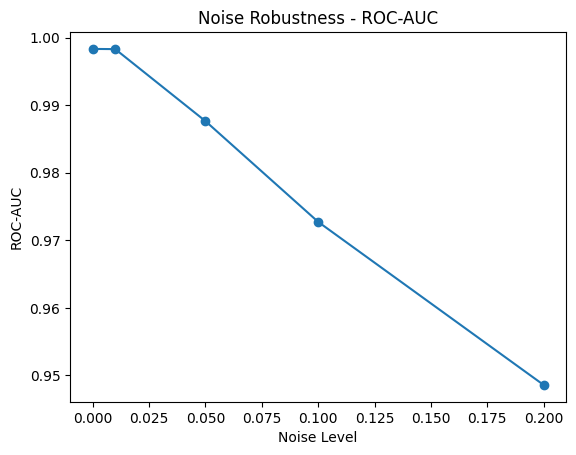

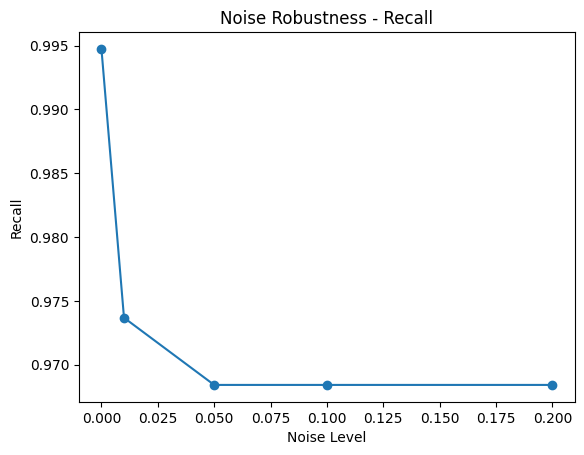

In [34]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(results_df["Noise Level"], results_df["ROC-AUC"], marker='o')
plt.xlabel("Noise Level")
plt.ylabel("ROC-AUC")
plt.title("Noise Robustness - ROC-AUC")
plt.show()

plt.figure()
plt.plot(results_df["Noise Level"], results_df["Recall"], marker='o')
plt.xlabel("Noise Level")
plt.ylabel("Recall")
plt.title("Noise Robustness - Recall")
plt.show()

In [ ]:
feature dropout

In [35]:
def random_feature_dropout(X, drop_rate=0.1):
    X_drop = X.copy()

    for col in X.columns:
        mask = np.random.rand(len(X)) < drop_rate
        X_drop.loc[mask, col] = X[col].mean()  # 用均值填充

    return X_drop

In [36]:
drop_rates = [0, 0.1, 0.2, 0.3]

drop_results = []

for dr in drop_rates:

    X_test_drop = random_feature_dropout(X_test, dr)

    y_pred = xgb_model.predict(X_test_drop)
    y_prob = xgb_model.predict_proba(X_test_drop)[:,1]

    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    drop_results.append([dr, acc, recall, auc])

drop_df = pd.DataFrame(drop_results, columns=["Drop Rate", "Accuracy", "Recall", "ROC-AUC"])
print(drop_df)

   Drop Rate  Accuracy    Recall   ROC-AUC
0        0.0  0.997638  0.994737  0.998328
1        0.1  0.952756  0.957895  0.987541
2        0.2  0.906299  0.926316  0.972135
3        0.3  0.870866  0.847368  0.935400


In [ ]:
SHAP 分析各个特征的重要性

In [37]:
!pip install shap

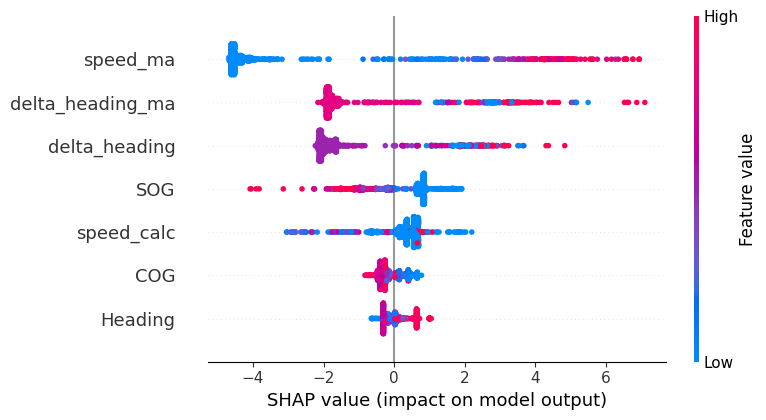

In [38]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [39]:
import numpy as np

feature_importance = np.abs(shap_values).mean(axis=0)

importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

print(importance_df)

            Feature  Importance
5          speed_ma    4.228390
6  delta_heading_ma    1.944398
4     delta_heading    1.937456
0               SOG    0.817514
3        speed_calc    0.551242
1               COG    0.306876
2           Heading    0.234928


In [ ]:
自适应 攻击

In [43]:
def adaptive_camouflage_attack(model, X_test, y_test, alphas):

    results = []

    # 只针对 spoof 样本
    spoof_mask = (y_test == 1)

    for alpha in alphas:

        X_adv = X_test.copy()

        # 对关键异常特征进行“强度衰减”
        for col in ["speed_ma", "delta_heading_ma", "delta_heading"]:
            X_adv.loc[spoof_mask, col] = (
                X_adv.loc[spoof_mask, col] * alpha
            )

        # 预测
        y_pred = model.predict(X_adv)
        y_prob = model.predict_proba(X_adv)[:, 1]

        recall = recall_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        acc = accuracy_score(y_test, y_pred)

        results.append({
            "alpha": alpha,
            "accuracy": acc,
            "recall": recall,
            "roc_auc": auc
        })

    return pd.DataFrame(results)

In [44]:
alphas = np.linspace(1.0, 0.1, 10)

df_attack = adaptive_camouflage_attack(
    xgb_model, X_test, y_test, alphas
)

print(df_attack)

   alpha  accuracy    recall   roc_auc
0    1.0  0.997638  0.994737  0.998328
1    0.9  0.996063  0.984211  0.998285
2    0.8  0.995276  0.978947  0.998270
3    0.7  0.994488  0.973684  0.998246
4    0.6  0.992913  0.963158  0.998177
5    0.5  0.991339  0.952632  0.998134
6    0.4  0.987402  0.926316  0.997904
7    0.3  0.979528  0.873684  0.997539
8    0.2  0.951969  0.689474  0.996043
9    0.1  0.903150  0.363158  0.991696


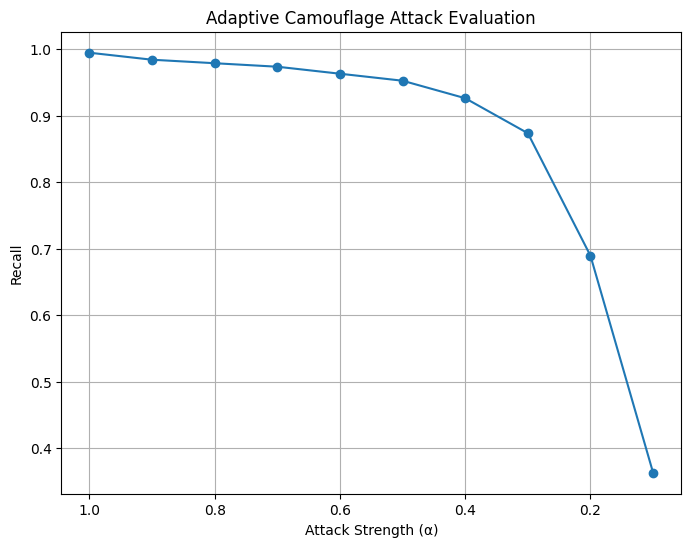

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(df_attack["alpha"], df_attack["recall"], marker='o')
plt.gca().invert_xaxis()

plt.xlabel("Attack Strength (α)")
plt.ylabel("Recall")
plt.title("Adaptive Camouflage Attack Evaluation")
plt.grid(True)
plt.show()

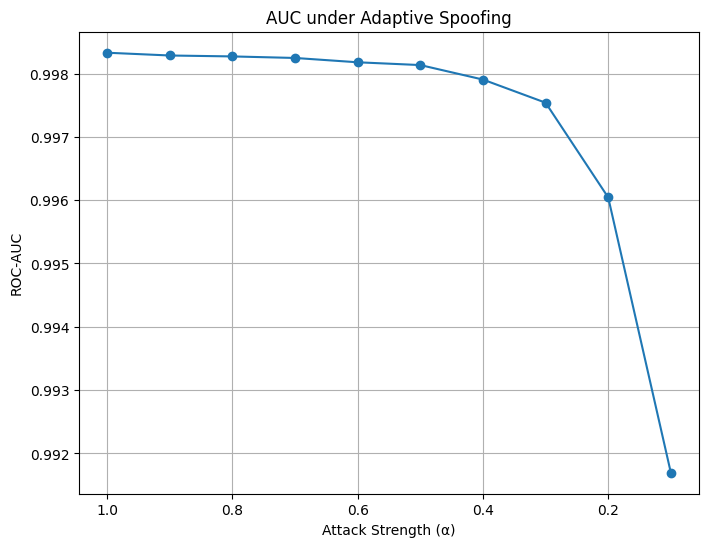

In [46]:
plt.figure(figsize=(8,6))
plt.plot(df_attack["alpha"], df_attack["roc_auc"], marker='o')
plt.gca().invert_xaxis()

plt.xlabel("Attack Strength (α)")
plt.ylabel("ROC-AUC")
plt.title("AUC under Adaptive Spoofing")
plt.grid(True)
plt.show()

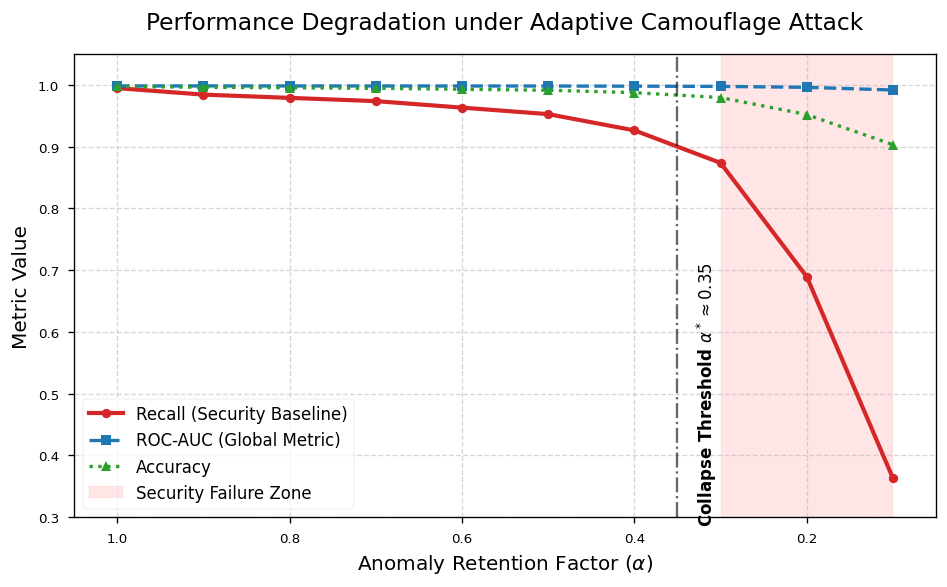

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. 整理你的实验数据
data = {
    'alpha': [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1],
    'accuracy': [0.997638, 0.996063, 0.995276, 0.994488, 0.992913, 0.991339, 0.987402, 0.979528, 0.951969, 0.903150],
    'recall': [0.994737, 0.984211, 0.978947, 0.973684, 0.963158, 0.952632, 0.926316, 0.873684, 0.689474, 0.363158],
    'roc_auc': [0.998328, 0.998285, 0.998270, 0.998246, 0.998177, 0.998134, 0.997904, 0.997539, 0.996043, 0.991696]
}
df = pd.DataFrame(data)

# 2. 设置绘图风格
plt.style.use('seaborn-v0_8-paper') # 或者使用 'ggplot'
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

# 3. 绘制三条核心曲线
# Recall 使用鲜明的红色代表安全警戒
ax.plot(df['alpha'], df['recall'], marker='o', color='#d62728', linewidth=2.5, label='Recall (Security Baseline)')
# ROC-AUC 使用蓝色，展示其“假稳定性”
ax.plot(df['alpha'], df['roc_auc'], marker='s', color='#1f77b4', linewidth=2, linestyle='--', label='ROC-AUC (Global Metric)')
# Accuracy 作为参考
ax.plot(df['alpha'], df['accuracy'], marker='^', color='#2ca02c', linewidth=2, linestyle=':', label='Accuracy')

# 4. 标注检测崩溃阈值 alpha* (约 0.35)
threshold = 0.35
ax.axvline(x=threshold, color='black', linestyle='-.', alpha=0.6)
ax.text(threshold-0.02, 0.5, 'Collapse Threshold $\\alpha^* \\approx 0.35$',
        rotation=90, verticalalignment='center', fontweight='bold')

# 5. 阴影标注：安全失效区域 (Failure Zone)
ax.fill_between(df['alpha'], 0, 1.1, where=(df['alpha'] <= threshold),
                color='red', alpha=0.1, label='Security Failure Zone')

# 6. 图表修饰
ax.set_title('Performance Degradation under Adaptive Camouflage Attack', fontsize=14, pad=15)
ax.set_xlabel('Anomaly Retention Factor ($\\alpha$)', fontsize=12)
ax.set_ylabel('Metric Value', fontsize=12)
ax.set_xlim(1.05, 0.05) # 反转 X 轴，展示从正常到攻击增强的过程
ax.set_ylim(0.3, 1.05)  # 聚焦 Recall 下跌的区间
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower left', frameon=True, fontsize=10)


plt.tight_layout()
plt.show()

To resolve the `SimHei` font warning and ensure proper display of Chinese characters, we need to install the font and update Matplotlib's font cache. Here's how you can do it in Google Colab:

1.  **Install the font**: We'll download a common Chinese font (e.g., from the `fonts-wqy-zenhei` package, which provides `wqy-zenhei.ttc` which is equivalent to `SimHei` for most purposes in Colab).
2.  **Update Matplotlib's font cache**: Clear the existing cache and rebuild it so Matplotlib can find the newly installed font.

In [50]:
# Install a Chinese font (e.g., wqy-zenhei) which includes SimHei or a similar equivalent
!apt-get update -qq
!apt-get install -qq fonts-wqy-zenhei

# Configure matplotlib to use the font
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Find the path to the installed font
font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'

# Add the font to matplotlib's font manager
fm.fontManager.addfont(font_path)

# Set the default font for matplotlib
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei'] # Use the installed font
plt.rcParams['axes.unicode_minus'] = False # Fix for negative signs

# Clear and rebuild matplotlib's font cache
fm._load_fontmanager()

print("Font 'WenQuanYi Zen Hei' installed and configured for Matplotlib.")
print("Please re-run your plotting cells to apply the changes.")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-wqy-zenhei.
(Reading database ... 117540 files and directories currently installed.)
Preparing to unpack .../fonts-wqy-zenhei_0.9.45-8_all.deb ...
Unpacking fonts-wqy-zenhei (0.9.45-8) ...
Setting up fonts-wqy-zenhei (0.9.45-8) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Font 'WenQuanYi Zen Hei' installed and configured for Matplotlib.
Please re-run your plotting cells to apply the changes.
